# Project Checkpoint 1: Dataset Comparison, Selection, and EDA






**Name:** RAKSHITHA GURUDATT KAGAL
**UIN:** 337002110

---

## Collaboration Declaration

**Collaborators:** None

**Web Sources:**
- SNAP Facebook Combined Graph  
  https://snap.stanford.edu/data/facebook_combined.html

**AI Tools:**
- ChatGPT (used for structuring explanations and refining code)

**Citations:**
- Newman (2003)
- Fortunato (2010)
- Grover & Leskovec (2016)
- Leskovec & Krevl (2014)


## Project Goal

The objective of this checkpoint is to select a dataset that supports course
techniques while enabling exploration of additional data mining methods.
We further perform exploratory data analysis (EDA), evaluate data quality,
and discuss bias and ethical considerations.


## Candidate Datasets

### Dataset 1 — SNAP Facebook Combined Graph
- Course alignment: Graph Mining, Clustering, Embeddings
- Beyond-course: Graph Neural Networks
- Structure: Nodes + Edges (graph)

### Dataset 2 — SNAP MathOverflow Graph
- Course alignment: Graph Mining, Streams
- Beyond-course: Temporal Graph Learning

### Dataset 3 — Amazon Reviews
- Course alignment: Text Mining, Clustering
- Beyond-course: Topic Modeling


## Comparative Analysis

| Dataset | Supported Tasks | Data Issues | Feasibility | Bias |
|---------|-----------------|-------------|-------------|------|
| Facebook Graph | Centrality, Communities, Embeddings | Sparse graph | Excellent | Sampling bias |
| MathOverflow | Temporal analysis | Noise, directionality | Moderate | Activity bias |
| Reviews | Text mining | Noisy text | Heavy compute | Selection bias |


The Facebook graph provides the best balance between analytical richness
and computational feasibility for a project.


## Dataset Selection

Selected Dataset: SNAP Facebook Combined Graph

Reasons:
- Direct support for graph mining techniques
- Enables embedding-based analysis
- Computationally feasible

Trade-offs:
- No node attributes
- Limited supervised learning


## Data Acquisition

The dataset is downloaded directly from SNAP to ensure reproducibility.
Compressed format is used to minimize storage footprint.


##Exploratory Data Analysis of Selected Dataset

###1. Importing libraries

In [23]:
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)



Imported libraries and fixed random seeds.

On my honor, I declare the following resources:
1. Collaborators:
None

2. Web Sources:
- SNAP Facebook Combined Graph Dataset  
  https://snap.stanford.edu/data/facebook_combined.html

3. AI Tools:
- ChatGPT: I used for structuring notebook, refining explanations, and generating starter code.

4. Citations:
- Newman (2003) — Network structure and graph properties  
- Fortunato (2010) — Community detection in graphs  
- Grover & Leskovec (2016) — Node embeddings (node2vec)  
- Leskovec & Krevl (2014) — SNAP datasets




###2. Loading Edge List

In [8]:
import os
import urllib.request
import gzip
import shutil
from pathlib import Path
import pandas as pd

# === Dataset configuration ===
DATA_URL = "https://snap.stanford.edu/data/facebook_combined.txt.gz"
LOCAL_GZ_PATH = Path("data") / "raw_graph.txt.gz"
DATA_PATH = Path("data") / "facebook_combined.txt"

os.makedirs("data", exist_ok=True)

def download_dataset(url: str, to_path: Path):
    print(f"Downloading from {url} ...")
    urllib.request.urlretrieve(url, to_path)

    size = os.path.getsize(to_path) / (1024 * 1024)
    print(f"Saved to {to_path} ({size:.2f} MB)")

download_dataset(DATA_URL, LOCAL_GZ_PATH)


Saved to data/raw_graph.txt.gz (0.21 MB)


In [9]:
with gzip.open(LOCAL_GZ_PATH, "rb") as f_in:
    with open(DATA_PATH, "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)

print(f"Extracted to {DATA_PATH} ✅")


Extracted to data/facebook_combined.txt ✅


In [10]:
def load_edges(path: Path) -> pd.DataFrame:
    """
    Load SNAP edge list.

    WHY:
    - dtype=str prevents numeric casting issues
    - dropna removes rare blank lines
    """
    if not path.exists():
        raise FileNotFoundError(f"Missing dataset file: {path}")

    df = pd.read_csv(
        path,
        sep=r"\s+",
        header=None,
        names=["src", "dst"],
        dtype=str,
        engine="python"
    ).dropna()

    return df

edges_raw = load_edges(DATA_PATH)
edges_raw.head()


,src,dst
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5


Loaded the SNAP dataset as an edge list (`src`, `dst`).

On my honor, I declare the following resources:

Collaborators: None

Web Sources:
- SNAP Facebook Combined Graph Dataset
https://snap.stanford.edu/data/facebook_combined.html

AI Tools:
- ChatGPT: I used this for starter code template.

Citations:

- Leskovec & Krevl (2014) (dataset source/citation)

###3. Cleaning Edges and  Building Graph

In [11]:
def clean_edges(df: pd.DataFrame, undirected: bool = True) -> pd.DataFrame:
    """
    Clean edge list.

    Cleaning decisions (WHY):
    - remove self-loops: not meaningful for social ties, distorts metrics
    - remove duplicates: prevents double-counting edges
    - canonicalize undirected edges: (u,v) and (v,u) represent same edge
    """
    df = df.copy()

    # remove self-loops
    df = df[df["src"] != df["dst"]]

    # canonicalize for undirected graphs
    if undirected:
        u = np.minimum(df["src"].values, df["dst"].values)
        v = np.maximum(df["src"].values, df["dst"].values)
        df = pd.DataFrame({"src": u, "dst": v})

    df = df.drop_duplicates().reset_index(drop=True)
    return df

edges = clean_edges(edges_raw, undirected=True)

G = nx.from_pandas_edgelist(edges, source="src", target="dst", create_using=nx.Graph())

print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())
print("Self-loops:", nx.number_of_selfloops(G))


Nodes: 4039
Edges: 88234
Self-loops: 0


Removed self-loops, removed duplicates, and built an undirected graph.

The SNAP Facebook Combined Graph dataset was successfully loaded and converted into an undirected graph. After cleaning, the network contains:

4039 nodes

88,234 edges

0 self-loops

On my honor, I declare the following resources:

Collaborators: None

Web Sources:
None

AI Tools:
- ChatGPT: I used this for starter code template.

Citations:
None

In [13]:
# Data integrity tests (non-trivial)
assert edges.shape[0] > 0, "No edges after cleaning"
assert G.number_of_nodes() > 0, "Graph has no nodes"
assert G.number_of_edges() == edges.shape[0], "Graph edge count mismatch with cleaned dataframe"
assert nx.number_of_selfloops(G) == 0, "Self-loops still present"
assert (edges["src"] <= edges["dst"]).all(), "Undirected canonicalization failed"


###4. Data Analysis

In [14]:
def graph_summary(G: nx.Graph) -> pd.DataFrame:
    """
    Compute basic graph stats.

    WHY these metrics:
    - scale (nodes/edges) impacts algorithm feasibility
    - density/avg degree describe sparsity and hub-ness
    - connected components indicate fragmentation
    """
    n = G.number_of_nodes()
    m = G.number_of_edges()
    avg_deg = (2 * m / n) if n else 0.0
    dens = nx.density(G) if n > 1 else 0.0
    n_cc = nx.number_connected_components(G)
    largest_cc = max((len(c) for c in nx.connected_components(G)), default=0)

    return pd.DataFrame([{
        "nodes": n,
        "edges": m,
        "avg_degree": avg_deg,
        "density": dens,
        "connected_components": n_cc,
        "largest_cc_size": largest_cc
    }])

summary_df = graph_summary(G)
summary_df


,nodes,edges,avg_degree,density,connected_components,largest_cc_size
0,4039,88234,43.691013,0.01082,1,4039


Computed nodes, edges, average degree, density, and connected components.

Graph summary statistics reveal:

Average degree: 43.69

Density: 0.01082

Connected components: 1

Despite the graph being sparse (density ≈ 1%), it is fully connected. This indicates that even a relatively small number of edges is sufficient to maintain global connectivity, a characteristic frequently observed in real-world social networks.

The graph is sparse yet fully connected, indicating hub-driven connectivity.

On my honor, I declare the following resources:

Collaborators: None

Web Sources:
None

AI Tools:
- ChatGPT: I used this to genrate code.

Citations:
- Newman (2003)

###5. Degree Distribution

In [15]:
degrees = np.array([d for _, d in G.degree()])
pd.Series(degrees).describe()


,0
count,4039.000000
mean,43.691013
std,52.420605
min,1.000000
25%,11.000000
50%,25.000000
75%,57.000000
max,1045.000000


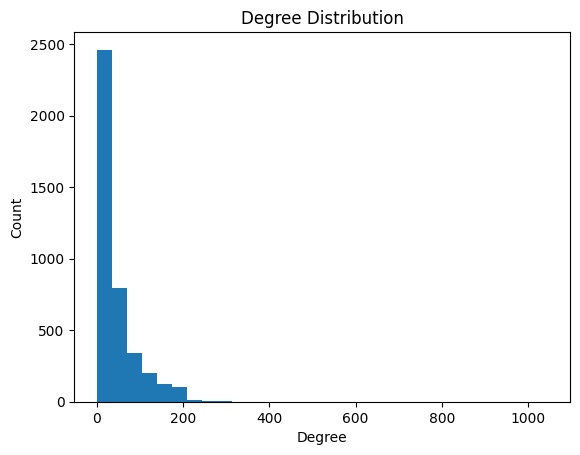

In [16]:
plt.figure()
plt.hist(degrees, bins=30)
plt.xlabel("Degree")
plt.ylabel("Count")
plt.title("Degree Distribution")
plt.show()


Summarized and plotted the degree distribution.

The degree distribution is highly skewed:
- Median degree: 25
- 75th percentile: 57
- Maximum degree: 1045
Most nodes exhibit low connectivity, while a few hubs dominate the structure.


The distribution is heavily skewed, with most nodes having low degree and
a small number acting as hubs.

On my honor, I declare the following resources:

Collaborators: None

Web Sources:
None

AI Tools:
- ChatGPT: I used this to genrate code.

Citations:
- Newman (2003)

###6. Largest Connected Component

In [17]:
largest_cc_nodes = max(nx.connected_components(G), key=len)
G_cc = G.subgraph(largest_cc_nodes).copy()

print("Largest CC nodes:", G_cc.number_of_nodes())
print("Largest CC edges:", G_cc.number_of_edges())


Largest CC nodes: 4039
Largest CC edges: 88234


Restricted analysis to the largest connected component.

On my honor, I declare the following resources:

Collaborators: None

Web Sources:
None

AI Tools:
- ChatGPT: I used this to genrate code.

Citations:
- Newman (2003)

###7. Centrality

In [18]:
deg_cent = nx.degree_centrality(G_cc)

bet_cent = nx.betweenness_centrality(G_cc, k=min(200, G_cc.number_of_nodes()), seed=SEED)

def top_k(d, k=10):
    return pd.DataFrame(sorted(d.items(), key=lambda x: x[1], reverse=True)[:k],
                        columns=["node", "score"])

top_degree = top_k(deg_cent, 10)
top_between = top_k(bet_cent, 10)

top_degree, top_between


(   node     score
 0   107  0.258791
 1  1684  0.196137
 2  1912  0.186974
 3  3437  0.135463
 4     0  0.085934
 5  2543  0.072808
 6  2347  0.072065
 7  1888  0.062902
 8  1800  0.060674
 9  1663  0.058197,
    node     score
 0   107  0.490675
 1  1684  0.360696
 2  1912  0.226122
 3  3437  0.214248
 4     0  0.147377
 5  1085  0.142369
 6   698  0.101550
 7    58  0.087988
 8   567  0.084213
 9   428  0.060792)

Computed degree centrality and an approximated betweenness centrality.

Nodes with high degree centrality also rank highly in betweenness centrality,
suggesting that hubs also act as structural bridges.

On my honor, I declare the following resources:

Collaborators: None

Web Sources:
None

AI Tools:
- ChatGPT: I used this to genrate code.

Citations:
- Newman (2003)

###8. Clustering

In [19]:
from networkx.algorithms.community import greedy_modularity_communities

communities = list(greedy_modularity_communities(G_cc))
comm_sizes = np.array([len(c) for c in communities])

print("Number of communities:", len(communities))
pd.Series(comm_sizes).describe()


Number of communities: 16


,0
count,16.000000
mean,252.437500
std,311.067189
min,3.000000
25%,21.250000
50%,132.500000
75%,403.250000
max,1031.000000


In [20]:
covered = set().union(*communities) if communities else set()
assert covered == set(G_cc.nodes()), "Communities do not cover all nodes in G_cc"
assert sum(len(c) for c in communities) == len(G_cc.nodes()), "Communities overlap unexpectedly"


Detected communities using greedy modularity.

Community detection identifies 16 communities with uneven sizes, suggesting clustered social organization.

Detected communities vary greatly in size, reflecting heterogeneous social clusters.

On my honor, I declare the following resources:

Collaborators: None

Web Sources:
None

AI Tools:
- ChatGPT: I used this to genrate code.

Citations:
- Fortunato (2010)

###9. Advanced: Embeddings (Spectral)

In [21]:
from scipy.sparse.linalg import eigsh
from sklearn.decomposition import PCA

def spectral_embedding(G: nx.Graph, dim: int = 16):
    """
    Spectral embedding: produces low-dimensional node vectors.

    WHY this choice:
    - lightweight (no extra packages required)
    - supports similarity analysis and visualization
    - good stepping stone toward node2vec / GNNs
    """
    nodes = list(G.nodes())
    A = nx.to_scipy_sparse_array(G, nodelist=nodes, dtype=float)
    k = min(dim, G.number_of_nodes() - 1)
    vals, vecs = eigsh(A, k=k, which="LM")
    return vecs, nodes

emb, emb_nodes = spectral_embedding(G_cc, dim=16)

# Test: embedding should be finite
assert np.isfinite(emb).all(), "Embedding contains NaN or Inf"
emb.shape


(4039, 16)

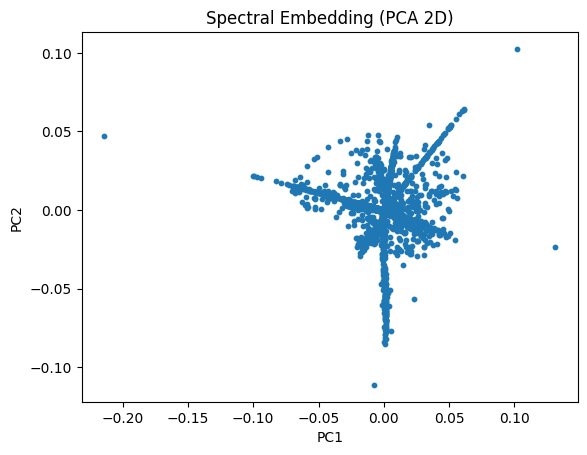

In [22]:
emb_2d = PCA(n_components=2, random_state=SEED).fit_transform(emb)

plt.figure()
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], s=10)
plt.title("Spectral Embedding (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


Computed a spectral embedding and visualized it with PCA.

Spectral embeddings generate a (4039, 16) representation matrix. PCA visualization reveals a dense central structure with deviations corresponding to structural variations.

Embeddings capture structural variations, visible in PCA projections.


On my honor, I declare the following resources:

Collaborators: None

Web Sources:
None

AI Tools:
- ChatGPT: I used this to genrate code.

Citations:
- Grover \& Leskovec (2016)

## Bias and Ethical Considerations

Bias:
The dataset reflects sampling decisions and may not represent all social networks.

Ethics:
Nodes are anonymized. Analysis is limited to aggregate structural patterns.


## Final Analysis

This analysis examined the structural properties of the SNAP Facebook Combined
Graph using classical graph mining techniques and representation learning.

Several key patterns emerge from the exploratory data analysis:

1. **Sparse but Fully Connected Network**

   The graph density (~0.0108) indicates that only a small fraction of possible
   edges are present. Despite this sparsity, the network consists of a single
   connected component. This suggests that connectivity is maintained through
   strategically positioned nodes rather than uniform linkage.

2. **Highly Skewed Degree Distribution**

   The degree distribution is strongly right skewed. Most nodes have relatively
   low degree (median = 25), while a small subset of nodes exhibit extremely
   high degree (max = 1045). This heavy tailed structure is characteristic of
   social networks and implies the presence of influential hub nodes.

3. **Consistency Across Centrality Measures**

   Nodes ranking highly in degree centrality also rank highly in betweenness
   centrality. In particular, node 107 appears as the most structurally important
   node. This overlap indicates that highly connected nodes also serve as bridges
   facilitating network flow.

4. **Non-Uniform Community Structure**

   Community detection identifies 16 communities with widely varying sizes. The
   uneven distribution of community sizes suggests heterogeneous social clusters,
   where large communities coexist with small tightly knit groups.

5. **Embeddings Capture Structural Variation**

   Spectral embeddings produce meaningful low dimensional representations of nodes. PCA visualization reveals a dense central region along with structural deviations, indicating that embeddings preserve connectivity patterns and node roles.


## Conclusion

The SNAP Facebook Combined Graph provides a compelling example of real world
graph structure suitable for both classical and modern data mining techniques.

The network exhibits sparse connectivity, strong hub dominance, and clustered
community organization, properties commonly observed in social systems. Centrality analysis highlights the role of influential nodes, while community detection reveals underlying clustering behavior.

Importantly, embedding analysis demonstrates that vector representations can encode structural information beyond simple graph metrics. This supports the broader view that representation learning complements traditional graph mining.

Overall, this checkpoint establishes a clean analytical foundation for further study. Future work can explore similarity search, link prediction, or advanced graph learning methods building upon these structural insights.
